# Imports

In [71]:
# General modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os.path import sep
from tqdm import tqdm

# Local modules
import disc_score

# Enable re-load of local modules every time they are called
%load_ext autoreload
%autoreload 2
%aimport numpy 
%aimport pandas

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [9]:
home_folder = 'Documents{0}CEGIS{0}DiscSim'.format(sep)
filename = '{0}{1}sample ecd child data ADQ.xlsx'.format(home_folder, sep)

data = pd.read_excel(filename) # Read data from the excel sheet
variables = data.columns       # Each column is a single variable measured, this gives the names of columns
n_variables = len(variables)

print('The following variables were found in this dataset:')
for v in variables:
    print('    {0}'.format(v))

The following variables were found in this dataset:
    child_id
    stunting_aww
    wasting_aww
    underweight_aww
    gender_cat_ss
    weight_ss
    height_ss
    age_in_months_ss
    haz06_ss
    waz06_ss
    whz06_ss
    bmiz06_ss
    stunting_ss
    wasting_ss
    underweight_ss
    height_aww
    weight_aww
    measurement_date_aww


In [10]:
# To access any of the variables, use data.<variable name> -- for example:
data.child_id

0      2998424
1      3250679
2      3297596
3      3300262
4      3300591
        ...   
480    6469093
481    6469166
482    6470304
483    6472322
484    6474014
Name: child_id, Length: 485, dtype: int64

In [11]:
# To access a particular sample, use data.<variable name>[sample number] -- for example:
data.child_id[53]

4124209

# Identify measured variables

In [12]:
supervisor_variables = []
subordinate_variables = []

for v in variables: # Loop over variables (in each loop iteration, 'v' will take on the value of the next variable)
    
    variable_type = v[v.rindex('_') + 1:] # Returns the characters in v after the last occurence of '_'
    
    if variable_type == 'aww':
        subordinate_variables.append(v)
    else:
        if variable_type == 'ss':
            supervisor_variables.append(v)
            
print('Subordinate variables: {0}'.format(subordinate_variables))
print('Supervisor_variables: {0}'.format(supervisor_variables))

Subordinate variables: ['stunting_aww', 'wasting_aww', 'underweight_aww', 'height_aww', 'weight_aww', 'measurement_date_aww']
Supervisor_variables: ['gender_cat_ss', 'weight_ss', 'height_ss', 'age_in_months_ss', 'haz06_ss', 'waz06_ss', 'whz06_ss', 'bmiz06_ss', 'stunting_ss', 'wasting_ss', 'underweight_ss']


## Find variables measured by both subordinate and supervisor

In [13]:
subordinate_only = []
supervisor_only = []
subordinate_and_supervisor = []

supervisor_variable_names = [v[:v.rindex('_')] for v in supervisor_variables] # Characters in v before the last occurence of '_'

for v in subordinate_variables:
    
    variable_name = v[:v.rindex('_')] # Characters in v before the last occurence of '_'
    
    if variable_name in supervisor_variable_names:
        subordinate_and_supervisor.append(variable_name)
        
    else:
        subordinate_only.append(variable_name)
        
supervisor_only = [v for v in supervisor_variable_names if np.logical_and(np.logical_not(v in subordinate_only),
                                                                         np.logical_not(v in subordinate_and_supervisor))]

print('The following variables are measured by both subordinate and supervisor:')
for v in subordinate_and_supervisor:
    print('    {0}'.format(v))
print('')

print('The following variables are measured only by subordinate:')
for v in subordinate_only:
    print('    {0}'.format(v))
print('')
    
print('The following variables are measured only by supervisor:')
for v in supervisor_only:
    print('    {0}'.format(v))

The following variables are measured by both subordinate and supervisor:
    stunting
    wasting
    underweight
    height
    weight

The following variables are measured only by subordinate:
    measurement_date

The following variables are measured only by supervisor:
    gender_cat
    age_in_months
    haz06
    waz06
    whz06
    bmiz06


# Discrepancy score calculation

## Discrete variables

In [49]:
# Stunting is a ternary variable, with three possible values. 
print('Stunting may be one of the following: {0}'.format(np.unique(data.stunting_aww)))
      
# We want to know how often the subordinate and supervisor reported different stunting values, so a good method for discrepancy score calculation would be percentage of non-matching entries.
score = disc_score.discrepancy_score(data.stunting_aww, data.stunting_ss, "percent_non_match")
print('{0}% of entries are not matching between stunting reported by subordinate and supervisor.'.format(np.round(score, 2)))    
print('')

# Similarly, wasting is a variable, with five possible values:
print('Wasting may be one of the following: {0}'.format(np.unique(data.wasting_aww)))

# Again we want to know how often it was not matching:
score = disc_score.discrepancy_score(data.wasting_aww, data.wasting_ss, "percent_non_match")
print('{0}% of entries are not matching between wasting reported by subordinate and supervisor.'.format(np.round(score, 2)))    
print('')

# Similarly for underweight:
print('Underweight may be one of the following: {0}'.format(np.unique(data.underweight_aww)))

# Again we want to know how often it was not matching:
score = disc_score.discrepancy_score(data.underweight_aww, data.underweight_ss, "percent_non_match")
print('{0}% of entries are not matching between underweight reported by subordinate and supervisor.'.format(np.round(score, 2)))    
print('')


Stunting may be one of the following: ['Normal' 'moderate stunting' 'severe stunting']
27.42% of entries are not matching between stunting reported by subordinate and supervisor.

Wasting may be one of the following: ['Normal' 'Obese' 'Overweight' 'moderate wasting' 'severe wasting']
23.92% of entries are not matching between wasting reported by subordinate and supervisor.

Underweight may be one of the following: ['Normal' 'moderately underweight' 'severely underweight']
21.44% of entries are not matching between underweight reported by subordinate and supervisor.



## Continous variables

In [50]:
# For continuous variables like height and weight, we can use a absolute difference, as we do not expect exact matches. 
print('Absolute difference')
score = disc_score.discrepancy_score(data.height_aww, data.height_ss, "absolute_difference")
print('Height reported by subordinate and supervisor differ by {0} units on average.'.format(np.round(score, 2)))
score = disc_score.discrepancy_score(data.weight_aww, data.weight_ss, "absolute_difference")
print('Weight reported by subordinate and supervisor differ by {0} units on average.'.format(np.round(score, 2)))
print('')

# We can also use a simple difference, in which the sign of the difference matters. These values will be smaller on average, because some of them will be negative and some positive, and they'll cancel each other out.
print('Simple difference')
score = disc_score.discrepancy_score(data.height_aww, data.height_ss, "simple_difference")
print('Height reported by subordinate and supervisor differ by {0} units on average.'.format(np.round(score, 2)))
score = disc_score.discrepancy_score(data.weight_aww, data.weight_ss, "simple_difference")
print('Weight reported by subordinate and supervisor are differ by {0} units on average.'.format(np.round(score, 2)))
print('')

# It may make more sense to calculate difference as a percentage of the supervisor variable:
print('Absolute percent difference')
score = disc_score.discrepancy_score(data.height_aww, data.height_ss, "absolute_percent_difference")
print('Height reported by subordinate and supervisor differ by {0}% of supervisor weight on average.'.format(np.round(score, 2)))
score = disc_score.discrepancy_score(data.weight_aww, data.weight_ss, "absolute_percent_difference")
print('Weight reported by subordinate and supervisor differ by {0}% of supervisor weight on average.'.format(np.round(score, 2)))
print('')

print('Simple percent difference')
score = disc_score.discrepancy_score(data.height_aww, data.height_ss, "percent_difference")
print('Height reported by subordinate and supervisor differ by {0}% of supervisor weight on average.'.format(np.round(score, 2)))
score = disc_score.discrepancy_score(data.weight_aww, data.weight_ss, "percent_difference")
print('Weight reported by subordinate and supervisor are differ by {0}% of supervisor height on average.'.format(np.round(score, 2)))
print('')

Absolute difference
Height reported by subordinate and supervisor differ by 3.84 units on average.
Weight reported by subordinate and supervisor differ by 0.9 units on average.

Simple difference
Height reported by subordinate and supervisor differ by -0.52 units on average.
Weight reported by subordinate and supervisor are differ by 0.06 units on average.

Absolute percent difference
Height reported by subordinate and supervisor differ by 4.66% of supervisor weight on average.
Weight reported by subordinate and supervisor differ by 9.02% of supervisor weight on average.

Simple percent difference
Height reported by subordinate and supervisor differ by -0.35% of supervisor weight on average.
Weight reported by subordinate and supervisor are differ by 1.45% of supervisor height on average.



## Sanity checks

In [51]:
# The method discrepancy_score will throw errors if there are issues with the variables entered for comparison. 

### Variable length

In [52]:
# If the two variables have different length:
x = [1, 2, 3, 4, 5]
y = [1, 2, 3, 4, 5, 6]
disc_score.discrepancy_score(x, y, 'simple_difference')

ValueError: The two variables must be the same length.

### Data type

In [55]:
# If the two variables are of different types:
disc_score.discrepancy_score(data.stunting_aww, data.height_ss, 'simple_difference')

TypeError: The two variables must be the same type.

# Measure confidence in the discrepancy score

For the rest of this analysis, we'll focus on wasting and use the percentage of non-matching entries as our discrepancy score calculation method.

## Generate a distribution of discrepancy scores using bootstrapping

100%|██████████████████████████████████████| 10000/10000 [00:28<00:00, 356.50it/s]


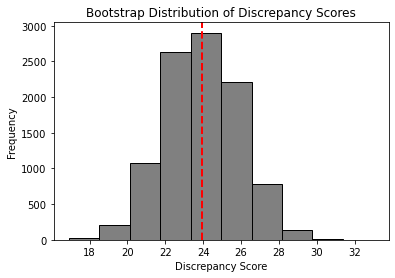

In [128]:
discrepancy_scores = disc_score.bootstrap_distribution(data.wasting_aww, data.wasting_ss, "percent_non_match", n_iterations = 10000)